# Cálculo error de análisis químicos almacenados en ipa 

In [ ]:
import psycopg2
import numpy as np

In [5]:
con = psycopg2.connect("dbname=ipa user=postgres password=****")
cur = con.cursor()

## Columnas de la vista

In [14]:
selectv =\
"""
SELECT attname AS column_name, format_type(atttypid, atttypmod) AS data_type
FROM pg_attribute
WHERE  attrelid = 'quim.w_analisis_mayor_pivot'::regclass
ORDER BY attnum;
"""

In [26]:
cur.execute(selectv)

In [24]:
for i, row in enumerate(cur.fetchall()):
    print(row)

('fid', 'character varying')
('fecha', 'character varying')
('bicarb', 'real')
('ca', 'real')
('clorur', 'real')
('k', 'real')
('mg', 'real')
('na', 'real')
('nitrat', 'real')
('sulfat', 'real')


In [27]:
names = [row[0] for row in cur.fetchall()]
header = ', '.join(names)
header

'fid, fecha, bicarb, ca, clorur, k, mg, na, nitrat, sulfat'

## Datos

In [28]:
select1 = \
"""
select a.*
from quim.w_analisis_mayor_pivot a
order by a.fid, a.fecha
"""

In [46]:
cur.execute(select1)

In [31]:
print(header)
for i, row in enumerate(cur.fetchall()):
    print(row)
    if i==5:
        break

fid, fecha, bicarb, ca, clorur, k, mg, na, nitrat, sulfat
('AB070001', '2007-01-17 16:20:00+01', 318.0, 97.0, 177.0, 2.0, 57.0, 43.0, 17.0, 60.0)
('AB070004', '2002-02-28 00:00:00+01', 320.0, 73.0, 19.0, 0.79, 28.0, 9.4, 39.0, 16.0)
('AB070004 ', '2019-03-21 11:00:00+01', 319.0, 82.0, 0.0, 0.97, 29.0, 10.0, 40.0, 22.0)
('AB070005', '2007-01-16 11:25:00+01', 339.0, 74.0, 26.0, 1.3, 29.0, 16.0, 15.0, 30.0)
('AB070005 ', '2019-03-21 13:45:00+01', 328.0, 80.0, 26.0, 1.3, 28.0, 17.0, 11.0, 24.0)
('AB070008', '2007-01-17 11:55:00+01', 269.0, 95.0, 114.0, 2.9, 49.0, 62.0, 36.0, 174.0)


In [55]:
def get_error_analisis(**kwargs):
    """
    devuelve el error en el balance ionico de un analisis de agua
    Los argumentos son las concentraciones de los iones en mg/l
    los argumentos requeridos son:
        aniones: bicarb, clorur, sulfat
        cationes: ca, mg, na
    los opcionales son: nitrat y k
    """
    aniones = (kwargs['bicarb'], kwargs['clorur'], kwargs['sulfat'], kwargs['nitrat'])
    aniones_pe = (61.02, 35.46, 48.03, 62.0)
    cationes = (kwargs['ca'], kwargs['mg'], kwargs['na'], kwargs['k'])
    cationes_pe = (20.04, 12.16, 22.99, 39.1)

    sum_anion = 0.0
    for anion, pe in zip(aniones[0:3], aniones_pe[0:3]):
        if anion is None or anion < 0.001:
            return None
        else:
            sum_anion += anion / pe

    if kwargs['nitrat'] is not None and kwargs['nitrat'] > 0:
        sum_anion += kwargs['nitrat'] / aniones_pe[3]
    
    sum_cation = 0.0
    for cation, pe in zip(cationes[0:3], cationes_pe[0:3]):
        if cation is None or cation < 0.001:
            return None
        else:
            sum_cation += cation / pe
 
    if kwargs['k'] is not None and kwargs['k'] > 0:
        sum_cation += kwargs['k'] / cationes_pe[3]
    
    return round(100 * abs(sum_anion - sum_cation) / (sum_anion + sum_cation) , 2)                                                     


In [32]:
aniones = ('bicarb', 'clorur', 'sulfat', 'nitrat')
aniones[0:3]

('bicarb', 'clorur', 'sulfat')

In [56]:
# fid, fecha, bicarb, ca, clorur, k, mg, na, nitrat, sulfat
cur.execute(select1)
print('fid', 'fecha', 'error %')
for i, row in enumerate(cur.fetchall()):
    balan = get_error_analisis(bicarb=row[2], ca=row[3], clorur=row[4],
                      k=row[5], mg=row[6], na=row[7], nitrat=row[8], sulfat=row[9])
    print(row[0:2], balan)
    if i == 10:
        break
    

fid fecha error %
('AB070001', '2007-01-17 16:20:00+01') 1.2
('AB070004', '2002-02-28 00:00:00+01') 2.8
('AB070004 ', '2019-03-21 11:00:00+01') None
('AB070005', '2007-01-16 11:25:00+01') 2.5
('AB070005 ', '2019-03-21 13:45:00+01') 2.03
('AB070008', '2007-01-17 11:55:00+01') 1.22
('AB070008 ', '2019-02-06 11:30:00+01') 5.32
('AB070010', '2007-01-17 13:25:00+01') 0.42
('AB070010 ', '2019-02-11 09:30:00+01') 2.34
('AB070013', '2002-02-28 00:00:00+01') 3.31
('AB070013 ', '2019-03-12 12:15:00+01') 3.97


In [57]:
cur.execute(select1)
items = [[row[0], row[1], get_error_analisis(bicarb=row[2],
                                            ca=row[3], clorur=row[4], k=row[5],
                                            mg=row[6], na=row[7], nitrat=row[8],
                                            sulfat=row[9])] for row in cur.fetchall()]
for i, row in enumerate(items):
    print(row)
    if i == 5:
        break
    

['AB070001', '2007-01-17 16:20:00+01', 1.2]
['AB070004', '2002-02-28 00:00:00+01', 2.8]
['AB070004 ', '2019-03-21 11:00:00+01', None]
['AB070005', '2007-01-16 11:25:00+01', 2.5]
['AB070005 ', '2019-03-21 13:45:00+01', 2.03]
['AB070008', '2007-01-17 11:55:00+01', 1.22]


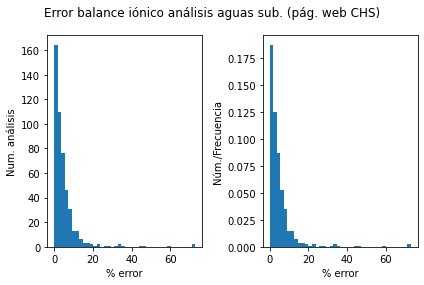

In [100]:
import matplotlib.pyplot as plt

dst = r'D:\IGME20\20211124_calidad_subt_chs\data\data2\histogram_errors.png'

results = np.array(items)
errors = np.array([item[2] for item in items if item[2] is not None])

n_bins = 40

fig, axs = plt.subplots(1, 2, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
fig.suptitle('Error balance iónico análisis aguas sub. (pág. web CHS)')
(n0, bins0, _) = axs[0].hist(errors, bins=n_bins)
plt.setp(axs[0], xlabel='% error', ylabel='Num. análisis')
(n1, bins1, _) = axs[1].hist(errors, bins=n_bins, density=True)
plt.setp(axs[1], xlabel='% error', ylabel='Núm./Frecuencia')
plt.savefig(dst)

In [98]:
print('Error,','Núm. análisis,', 'Num./Frecuencia')
for row in zip(bins[1:n_bins], n0, n1):
    print(f'{row[0]:0.1f},{row[1]:0.0f},{row[2]*100.:0.2f}')

Error, Núm. análisis, Num./Frecuencia
1.8,164,18.70
3.7,110,12.54
5.5,76,8.67
7.3,46,5.25
9.1,31,3.53
10.9,13,1.48
12.8,13,1.48
14.6,6,0.68
16.4,3,0.34
18.2,3,0.34
20.1,2,0.23
21.9,1,0.11
23.7,2,0.23
25.5,0,0.00
27.4,1,0.11
29.2,1,0.11
31.0,0,0.00
32.8,1,0.11
34.7,2,0.23
36.5,1,0.11
38.3,0,0.00
40.1,0,0.00
41.9,0,0.00
43.8,0,0.00
45.6,1,0.11
47.4,1,0.11
49.2,0,0.00
51.1,0,0.00
52.9,0,0.00
54.7,0,0.00
56.5,0,0.00
58.4,0,0.00
60.2,1,0.11
62.0,0,0.00
63.8,0,0.00
65.6,0,0.00
67.5,0,0.00
69.3,0,0.00
71.1,0,0.00


In [78]:
len(bins0)

41

In [80]:
patches0

<BarContainer object of 40 artists>